In [1]:
import pandas as pd, numpy as np, os, re
from bs4 import BeautifulSoup
from glob import iglob
import codecs
pd.set_option('display.max_columns', 40)

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, LeaveOneOut

from sklearn.model_selection import cross_val_score


In [3]:
from matplotlib import pyplot as plt

In [4]:
df_al = pd.read_csv('df_al.csv', sep=';')

In [5]:
df_al = df_al[df_al.Mileage != 'Not provided']

In [6]:
df_al.price = df_al.price.apply(lambda x: x.replace('$', '').replace(',', ''))
df_al.msrp_price = df_al.msrp_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)

df_al.original_price = df_al.original_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)
df_al.Mileage = df_al.Mileage.apply(lambda x: float(x.replace(',', '').strip()) if pd.notnull(x) else x)

In [7]:
df_al.seller_rating = df_al.seller_rating.astype('float')
df_al.car_rate = df_al.car_rate.astype('float')

df_al.n_photos = df_al.n_photos.apply(lambda x: int(x) if pd.notnull(x) else x)
df_al.seller_count_rating = df_al.seller_count_rating.astype('int')


In [8]:
df_al.consumers_review = df_al.consumers_review.apply(lambda x: int(x.replace('reviews', '').strip()) if pd.notnull(x) else x)

In [9]:
df_al.drop('id', inplace=True, axis=1)

df_al.fillna(-1, inplace=True)

In [10]:
df_al.price = df_al.price.astype('float')
df_al.msrp_price = df_al.msrp_price.astype('float')
df_al.original_price = df_al.original_price.astype('float')

In [11]:
df_al.drop(columns=['VIN', 'Stock', 'Interior Color'],inplace=True)

In [12]:
df_al_2 = df_al.drop(['Exterior Color'], axis=1)

In [13]:
df_al_2

,price,msrp_price,original_price,good_offer,seller_rating,seller_count_rating,car_rate,consumers_review,n_photos,City MPG,Drivetrain,Engine,Fuel Type,Highway MPG,Mileage,Transmission
0,23665.0,23665.0,NaN,NaN,4.6,122,4.3,129.0,15.0,30.0,FWD,1.4L I4 16V GDI DOHC Turbo,Gasoline,40.0,10.0,8-Speed Automatic
1,28994.0,NaN,NaN,Good Deal,4.8,1086,4.8,36.0,41.0,NaN,RWD,Twin Turbo Premium Unleaded V-6 3.0 L/183,Gasoline,NaN,37224.0,7-Speed Automatic w/OD
2,31000.0,34515.0,NaN,NaN,4.9,226,5.0,12.0,32.0,22.0,RWD,2.0L I4 16V GDI DOHC Turbo,Gasoline,29.0,5.0,8-Speed Automatic
3,19471.0,20230.0,NaN,NaN,5.0,169,4.4,45.0,18.0,NaN,FWD,1.6L I4 16V MPFI DOHC,Gasoline,NaN,10.0,Automatic CVT
4,22995.0,NaN,23995.0,Good Deal,4.8,1086,4.8,54.0,43.0,21.0,RWD,Premium Unleaded V-6 2.5 L/152,Gasoline,30.0,51225.0,6-Speed Automatic w/OD
5,28419.0,29980.0,NaN,NaN,4.9,287,4.7,25.0,9.0,25.0,FWD,2.5L I4 16V GDI DOHC,Gasoline,31.0,1.0,6-Speed Automatic
6,22574.0,24120.0,NaN,NaN,4.8,236,4.9,55.0,18.0,31.0,FWD,1.5L 1.5L I-4 DI DOHC Turbocharged,Gasoline,40.0,14.0,Automatic
7,33000.0,NaN,33800.0,Great Deal,4.6,289,4.7,97.0,29.0,19.0,AWD,3.5L V6 24V GDI SOHC,Gasoline,27.0,50180.0,9-Speed Automatic
8,17300.0,NaN,NaN,Good Deal,4.6,263,4.8,550.0,35.0,23.0,FWD,Intercooled Turbo Regular Unleaded I-4 1.5 L/91,Gasoline,30.0,75639.0,6-Speed Automatic w/OD
9,35285.0,NaN,NaN,Good Deal,4.5,63,4.6,81.0,32.0,16.0,RWD,8 Cylinder Engine 5.3L,Gasoline,22.0,89029.0,AUTOMATIC


In [14]:
def parse_cylinders(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+\.\d+", r['Engine']):
            return re.findall("\d+\.\d+", r['Engine'])[0]

df_al_2['Engine_cylinders'] = df_al_2.apply( parse_cylinders, axis=1)

In [15]:
def parse_engine_v(r):
    if pd.notnull(r['Engine']):
        if re.findall("[Vv-]\d+", r['Engine']) :
            v = re.findall("[Vv-]\d+", r['Engine'])[0]
            return v.replace("V", "").replace("v", "").replace("-", "")

df_al_2['Engine_v_type'] = df_al_2.apply( parse_engine_v, axis=1)

In [16]:
def parse_valves(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+[Vv]", r['Engine']) :
            valv = re.findall("\d+[Vv]", r['Engine'])[0]
            return valv.replace("V", "").replace("v", "")

df_al_2['Engine_valves'] = df_al_2.apply( parse_valves, axis=1)

In [17]:
def transmission_speeds(r):
    if pd.notnull(r['Transmission']):
        if re.findall("\d+\-", r['Transmission']) :
            tr = re.findall("\d+\-", r['Transmission'])[0]
            return tr.replace("-", "")

df_al_2['transm_speed'] = df_al_2.apply( transmission_speeds, axis=1)

In [18]:
def transmission_automatic(r):
    if pd.notnull(r['Transmission']):
        tr = r['Transmission'].lower()
        
        if tr.find('auto') != -1 or tr.find('cvt') != -1:
            return 1
        else:
            return 0

df_al_2['transm_type'] = df_al_2.apply( transmission_automatic, axis=1)

In [19]:
df_al_2.Engine_cylinders = df_al_2.Engine_cylinders.astype('float')
df_al_2.Engine_v_type = df_al_2.Engine_v_type.astype('float')
df_al_2.Engine_valves = df_al_2.Engine_valves.astype('float')

df_al_2.transm_speed = df_al_2.transm_speed.astype('float')
df_al_2.transm_type = df_al_2.transm_type.astype('float')

In [20]:
df_al_2.drop(['Engine', 'Transmission' ], axis=1, inplace=True)

In [21]:
df_al_2_bkp = df_al_2.copy()

In [22]:
dummies = ['Drivetrain', 'good_offer', 'Fuel Type']

for dummy in dummies:
    df_al_2 = pd.concat([df_al_2, pd.get_dummies(df_al_2[dummy], drop_first=True) ], axis=1)  
    df_al_2.drop(dummy, inplace=True, axis=1)
 

In [23]:
df_al_2.fillna(-1, inplace=True)

In [24]:
# df_al_bkp_2 = df_al.copy()

# df_al = df_al_bkp_2.copy()

### Linear Models

## TO-DO:
- Put Engine Type(Parsing)
- Year manufacturing
- Brand
- Model
- Type of transmission
- Numer of gears

In [25]:
X = df_al_2.drop('price',axis=1)
y = df_al_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3867, 42) (3867,)
(967, 42) (967,)


In [26]:
# X = df_al.drop('price', axis=1)
# y = df_al['price']

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


In [27]:
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.6496737729623623
0.5562997411637798


Text(0, 0.5, 'Predictions')

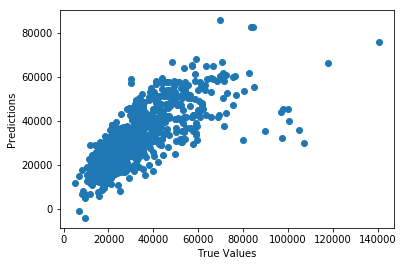

In [28]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Cross-validation

In [29]:
X = df_al_2.drop('price',axis=1)
y = df_al_2['price']

model = linear_model.LinearRegression()
scores = []
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
#     print(list(train))
    X_tr, y_tr = X.iloc[train], y.iloc[train]
    X_te, y_te = X.iloc[test], y.iloc[test]
    
    model.fit(X_tr,y_tr)
    score = model.score(X_te,y_te)

    scores.append(score)
    
print(scores)
print('\n', np.mean(scores))

[0.6687987630168067, 0.6046017425709082, 0.6210858917117446, 0.6183566294427513, 0.6285557922527583, 0.6069241030967771, 0.5411457480236979, 0.6583085631250083, 0.5968661181792179, 0.6560975974650394]

 0.620074094888471


# New York

In [30]:
df_al = pd.read_csv('df_ny.csv', sep=';')

In [31]:
df_al = df_al[df_al.Mileage != 'Not provided']

In [32]:
df_al.price = df_al.price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)
df_al.msrp_price = df_al.msrp_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)

df_al.original_price = df_al.original_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)
df_al.Mileage = df_al.Mileage.apply(lambda x: float(x.replace(',', '').strip()) if pd.notnull(x) else x)

In [33]:
df_al.seller_rating = df_al.seller_rating.astype('float')
df_al.car_rate = df_al.car_rate.astype('float')

df_al.n_photos = df_al.n_photos.apply(lambda x: int(x) if pd.notnull(x) else x)
df_al.seller_count_rating = df_al.seller_count_rating.astype('int')


In [34]:
df_al.consumers_review = df_al.consumers_review.apply(lambda x: int(x.replace('reviews', '').strip()) if pd.notnull(x) else x)

In [35]:
df_al.drop('id', inplace=True, axis=1)

df_al.fillna(-1, inplace=True)

In [36]:
df_al.price = df_al.price.astype('float')
df_al.msrp_price = df_al.msrp_price.astype('float')
df_al.original_price = df_al.original_price.astype('float')

In [37]:
df_al.drop(columns=['VIN', 'Stock', 'Interior Color'],inplace=True)

In [38]:
df_al_2 = df_al.drop(['Exterior Color'], axis=1)

In [39]:
df_al_2

,price,msrp_price,original_price,good_offer,seller_rating,seller_count_rating,car_rate,consumers_review,n_photos,City MPG,Drivetrain,Engine,Fuel Type,Highway MPG,Mileage,Transmission
0,24645.0,24645.0,NaN,NaN,2.7,77,4.9,55.0,3.0,31.0,FWD,1.5L I4 16V GDI DOHC Turbo,Gasoline,40.0,10.0,Automatic CVT
1,35302.0,NaN,NaN,Good Deal,4.7,1044,4.3,22.0,32.0,24.0,AWD,2.0L I4 16V GDI DOHC Turbo,Gasoline,33.0,5098.0,7-Speed Automatic with Auto-Shift
2,63165.0,NaN,NaN,NaN,4.9,740,5.0,1.0,6.0,19.0,AWD,6 Cylinder,Gasoline,27.0,0.0,9-Speed Shiftable Automatic
4,28997.0,NaN,NaN,Good Deal,4.8,660,4.8,23.0,32.0,17.0,AWD,Intercooled Turbo Premium Unleaded H-4 2.5 L/150,Gasoline,23.0,31698.0,6-Speed Manual w/OD
5,43336.0,NaN,NaN,NaN,4.5,80,4.5,14.0,32.0,19.0,AWD,3.5L V6 24V PDI DOHC,Gasoline,27.0,0.0,8-Speed Automatic
6,43340.0,NaN,NaN,NaN,4.9,740,5.0,6.0,4.0,23.0,AWD,4 Cylinder,Gasoline,31.0,0.0,Dual Shift Gearbox
7,38174.0,41635.0,NaN,NaN,3.0,10,4.5,27.0,32.0,15.0,RWD,5.0L V8 32V PDI DOHC,Gasoline,24.0,5.0,6-Speed Manual
8,58460.0,58960.0,NaN,NaN,4.9,869,4.8,6.0,11.0,NaN,quattro,Intercooled Turbo Premium Unleaded I-4 2.0 L/121,Gasoline,NaN,10.0,8-Speed Automatic w/OD
9,69425.0,NaN,NaN,NaN,4.6,48,NaN,NaN,3.0,21.0,AWD,2.0L I4 16V GDI DOHC,Gasoline,31.0,2.0,8-Speed Automatic
10,32980.0,32980.0,NaN,NaN,4.5,2105,NaN,NaN,23.0,NaN,RWD,4.0 L,Gasoline,NaN,8.0,Automatic


In [40]:
def parse_cylinders(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+\.\d+", r['Engine']):
            return re.findall("\d+\.\d+", r['Engine'])[0]

df_al_2['Engine_cylinders'] = df_al_2.apply( parse_cylinders, axis=1)

In [41]:
def parse_engine_v(r):
    if pd.notnull(r['Engine']):
        if re.findall("[Vv-]\d+", r['Engine']) :
            v = re.findall("[Vv-]\d+", r['Engine'])[0]
            return v.replace("V", "").replace("v", "").replace("-", "")

df_al_2['Engine_v_type'] = df_al_2.apply( parse_engine_v, axis=1)

In [42]:
def parse_valves(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+[Vv]", r['Engine']) :
            valv = re.findall("\d+[Vv]", r['Engine'])[0]
            return valv.replace("V", "").replace("v", "")

df_al_2['Engine_valves'] = df_al_2.apply( parse_valves, axis=1)

In [43]:
def transmission_speeds(r):
    if pd.notnull(r['Transmission']):
        if re.findall("\d+\-", r['Transmission']) :
            tr = re.findall("\d+\-", r['Transmission'])[0]
            return tr.replace("-", "")

df_al_2['transm_speed'] = df_al_2.apply( transmission_speeds, axis=1)

In [44]:
def transmission_automatic(r):
    if pd.notnull(r['Transmission']):
        tr = r['Transmission'].lower()
        
        if tr.find('auto') != -1 or tr.find('cvt') != -1:
            return 1
        else:
            return 0

df_al_2['transm_type'] = df_al_2.apply( transmission_automatic, axis=1)

In [45]:
df_al_2.Engine_cylinders = df_al_2.Engine_cylinders.astype('float')
df_al_2.Engine_v_type = df_al_2.Engine_v_type.astype('float')
df_al_2.Engine_valves = df_al_2.Engine_valves.astype('float')

df_al_2.transm_speed = df_al_2.transm_speed.astype('float')
df_al_2.transm_type = df_al_2.transm_type.astype('float')

In [46]:
df_al_2.drop(['Engine', 'Transmission' ], axis=1, inplace=True)

In [47]:
df_al_2_bkp = df_al_2.copy()

In [48]:
dummies = ['Drivetrain', 'good_offer', 'Fuel Type']

for dummy in dummies:
    df_al_2 = pd.concat([df_al_2, pd.get_dummies(df_al_2[dummy], drop_first=True) ], axis=1)  
    df_al_2.drop(dummy, inplace=True, axis=1)
 

In [49]:
df_al_2.fillna(-1, inplace=True)

In [50]:
# df_al_bkp_2 = df_al.copy()

# df_al = df_al_bkp_2.copy()

In [51]:
X = df_al_2.drop('price',axis=1)
y = df_al_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3736, 42) (3736,)
(935, 42) (935,)


In [52]:
# X = df_al.drop('price', axis=1)
# y = df_al['price']

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


In [53]:
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.46112270124578414
0.36344561445644963


Text(0, 0.5, 'Predictions')

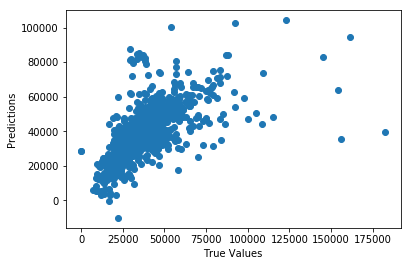

In [54]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [55]:
X = df_al_2.drop('price',axis=1)
y = df_al_2['price']

model = linear_model.LinearRegression()
scores = []
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
#     print(list(train))
    X_tr, y_tr = X.iloc[train], y.iloc[train]
    X_te, y_te = X.iloc[test], y.iloc[test]
    
    model.fit(X_tr,y_tr)
    score = model.score(X_te,y_te)

    scores.append(score)
    
print(scores)
print('\n', np.mean(scores))

[0.3864358050145038, 0.5440151838422883, 0.5499490355568168, 0.40062327770403944, 0.34158221880284356, 0.5446818811086768, 0.4027522523526972, 0.3588835024746992, 0.3901658725153775, 0.4279559681982989]

 0.4347044997570242
